In [1]:
# %load_ext autoreload
# %autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import sctop as top

In [2]:
sns.set(context='talk', color_codes=True, palette='deep', style='whitegrid',
        rc={'mathtext.fontset': 'cm', 'xtick.direction': 'in','ytick.direction': 'in',
            'axes.linewidth': 1.5, 'figure.dpi':400, 'text.usetex':False}) #font_scale=0.3,

from matplotlib.cm import ScalarMappable

def create_colorbar(data, label, colormap='rocket_r', ax = None, cax = None, pad = 0.1):

    cmap = plt.get_cmap(colormap)
    scalarmap = ScalarMappable(norm=plt.Normalize(min(data), max(data)),
                               cmap=cmap)
    scalarmap.set_array(data)
    cb_ax = plt.colorbar(scalarmap, label=label, ax=ax, cax=cax, fraction=0.03, pad=pad)
    
    return cb_ax

From [github](https://github.com/AllonKleinLab/paper-data/tree/master/Lineage_tracing_on_transcriptional_landscapes_links_state_to_fate_during_differentiation):
## Experiment 1: In vitro differentiation time course
"In this experiment, we isolated hematopoietic progenitor cells from mouse bone marrow, tagged them using the LARRY lentiviral barcode library, and then sampled them at three time points during culture (days 2, 4 and 6). We performed the experiment on two separate starting cell populations: Lin-Kit+Sca1+ (LSK) cells, and Lin-Kit+ (LK) cells. Our final dataset includes single-cell transcriptomes from each time point, as well as clonal labels and a cell type annotation for each mature cell."

In [3]:
from scipy.io import mmread

source_vitro = '/projectnb/biophys/mariay/mouse/samples/GSE140802 (bone marrow)/GSM4185642_'

metadata_vitro = pd.read_csv(source_vitro + 'stateFate_inVitro_metadata.txt', sep='\t')
counts_vitro = mmread(source_vitro + 'stateFate_inVitro_normed_counts.mtx')
clones_vitro = mmread(source_vitro + 'stateFate_inVitro_clone_matrix.mtx').tocsr()
genes_vitro = pd.read_csv(source_vitro + 'stateFate_inVitro_gene_names.txt', sep='\t', header=None)

counts_vitro = pd.DataFrame.sparse.from_spmatrix(counts_vitro).T
counts_vitro.index = genes_vitro.T.values[0]

# Indices of cells that have clones
clones_indices = clones_vitro.nonzero()[0]

enumerated_clones, clone_counts = np.unique(clones_vitro.nonzero()[1], return_counts=True)

time_points_types, type_counts = np.unique(metadata_vitro.loc[:, 'Time point'].astype('string') + ' ' 
                                           + metadata_vitro.loc[:, 'Cell type annotation'], return_counts=True)

In [5]:
clone_time_points = pd.DataFrame(index=enumerated_clones,
                                 columns=['Day 2', 'Day 4', 'Day 6'])

days = [2., 4., 6.]

# For each clone column, find which clones have multi-day sisters
for current_clone in enumerated_clones:
    current_sisters = clones_vitro[:,current_clone].nonzero()[0]
    current_timepoints = metadata_vitro.iloc[current_sisters].loc[:, 'Time point']
    for day in days:
        clone_time_points.loc[
            current_clone, "Day {}".format(int(day))] = (len(
            np.where(current_timepoints == day)[0]))

In [5]:
# Make the basis from in vitro day 6 samples

type_by_cell = (metadata_vitro.loc[:, 'Time point'].astype('string') + ' ' 
                                           + metadata_vitro.loc[:, 'Cell type annotation'])

# day6_types = time_points_types[22:]
# day6_counts = type_counts[22:]

# day6_types = day6_types[day6_counts>200]
# day6_counts = day6_counts[day6_counts>200]

day6_types = ['6.0 Neutrophil',
              '6.0 Monocyte',
              '6.0 Meg',
              '6.0 Mast',
              '6.0 Eos',
              '6.0 Baso',
              '2.0 Undifferentiated'
             ]

type_expressions_list = []
training_indices = []

for current_type in tqdm(day6_types):
    current_type_indices = np.where(type_by_cell==current_type)[0]

    # Drop cloned types
    current_type_indices = np.setdiff1d(current_type_indices, clones_indices)

    # Choose n_training cells to use for the basis
    n_training = 150
    random_indices = np.random.choice(current_type_indices, n_training, replace=False)
    training_indices += [random_indices]
    
    current_raw = counts_vitro.iloc[:, random_indices]
    current_processed = top.process(current_raw, average=True)
    type_expressions_list.append(current_processed)


training_indices = np.concatenate(training_indices)
day6_basis = pd.concat(type_expressions_list, axis=1)
day6_basis.columns = day6_types

100%|██████████| 7/7 [00:01<00:00,  6.30it/s]


In [6]:
# Dataframe of clone families with sisters across multiple days
# Also include information about what cell types they differentiate into
multiday_clones = pd.DataFrame(columns=['Day 2', 'Day 4', 'Day 6',
                                        *np.unique(metadata_vitro.loc[:, 'Cell type annotation'])])

for clone, row in tqdm(clone_time_points.iterrows()):
    has_day2 = row['Day 2'] > 0
    has_day4 = row['Day 4'] > 0
    has_day6 = row['Day 6'] > 0
    
    if has_day2 and (has_day4 or has_day6):
        current_types, current_counts = np.unique(metadata_vitro.loc[
            clones_vitro[:, clone].nonzero()[0]].loc[:,'Cell type annotation'], return_counts=True)
        
        for day in clone_time_points.columns:
            multiday_clones.loc[clone, day] = row[day]
        
        for cell_type, cell_counts in zip(current_types, current_counts):
            multiday_clones.loc[clone, cell_type] = cell_counts
            
multiday_clones = multiday_clones.fillna(0)

5864it [00:05, 1119.34it/s]


In [27]:
most_cells = multiday_clones.iloc[:, 3:-1].sum(axis=1).sort_values(ascending=False)[:50].index
multiday_clones.loc[most_cells]

,Day 2,Day 4,Day 6,Baso,Ccr7_DC,Eos,Erythroid,Lymphoid,Mast,Meg,Monocyte,Neutrophil,Undifferentiated,pDC
1261,1,19,157,1,0,0,0,0,0,0,30,113,33,0
5209,3,24,103,0,0,0,1,0,0,1,41,72,15,0
3345,2,17,105,0,0,0,0,0,1,0,20,80,23,0
2673,1,28,78,0,0,0,0,0,0,0,44,34,29,0
4256,1,18,86,0,0,0,0,0,0,0,33,7,65,0
3612,1,5,89,0,0,1,0,0,1,0,0,83,10,0
3165,1,20,72,0,0,0,0,0,0,0,28,39,26,0
3869,2,20,68,0,0,0,0,0,2,0,21,53,14,0
67,1,22,65,0,0,0,0,0,0,0,48,4,36,0
2831,1,17,69,1,0,1,0,0,0,0,14,60,11,0


In [8]:
# Keep track of clone family examples with each of the types of interest

clone_type_examples = {'Baso': 3093,
                       'Eos': 346,
                       'Mast': 755,
                       'Meg': 5062,
                       'Monocyte': 67
                      }

In [ ]:
clones_data_list = []

for clone_type in clone_type_examples.keys():
    current_indices = clones_vitro[:, clone_type_examples[clone_type]].nonzero()[0]
    clones_counts = counts_vitro.loc[:, current_indices]
    clones_processed = top.process(clones_counts)
    clones_scores = top.score(day6_basis, clones_processed)

    metadata_clones = metadata_vitro.iloc[current_indices]
    clones_days = metadata_clones.loc[:,'Time point']
    clones_families = pd.DataFrame(np.full_like(clones_days, clone_type_examples[clone_type]),
                                   index = clones_days.index,
                                   columns=['Clone'])
    current_data = pd.concat([clones_scores.T, clones_days, clones_families], axis=1)
    clones_data_list += [current_data]
    
clones_data = pd.concat(clones_data_list, axis=0)

In [48]:
# current_indices = clones_indices

# clone_family = 5209 # Neutrophil-monocyte
# clone_family = 346 # -phils
clone_family = 3612 # Neutrophil, no  monocyte

current_indices = clones_vitro[:,clone_family].nonzero()[0]

clones_counts = counts_vitro.loc[:,current_indices]
clones_processed = top.process(clones_counts)
clones_scores = top.score(day6_basis, clones_processed)

metadata_clones = metadata_vitro.iloc[current_indices]
clones_days = metadata_clones.loc[:,'Time point']
clones_data = pd.concat([clones_scores.T, clones_days], axis=1)

KeyboardInterrupt: 

In [17]:
label_dict = {'6.0 Neutrophil': 'Neutrophil',
              '6.0 Monocyte': 'Monocyte',
              '6.0 Meg': 'Megakaryocyte',
              '6.0 Mast': 'Mast Cell',
              '6.0 Eos': 'Eosiniphil',
              '6.0 Baso': 'Basophil',
              '2.0 Undifferentiated': 'Progenitor Cell'
             }

cols = [label_dict[col] for col in clones_data.columns if col != 'Time point']
clones_data.columns = [*cols, 'Time point']

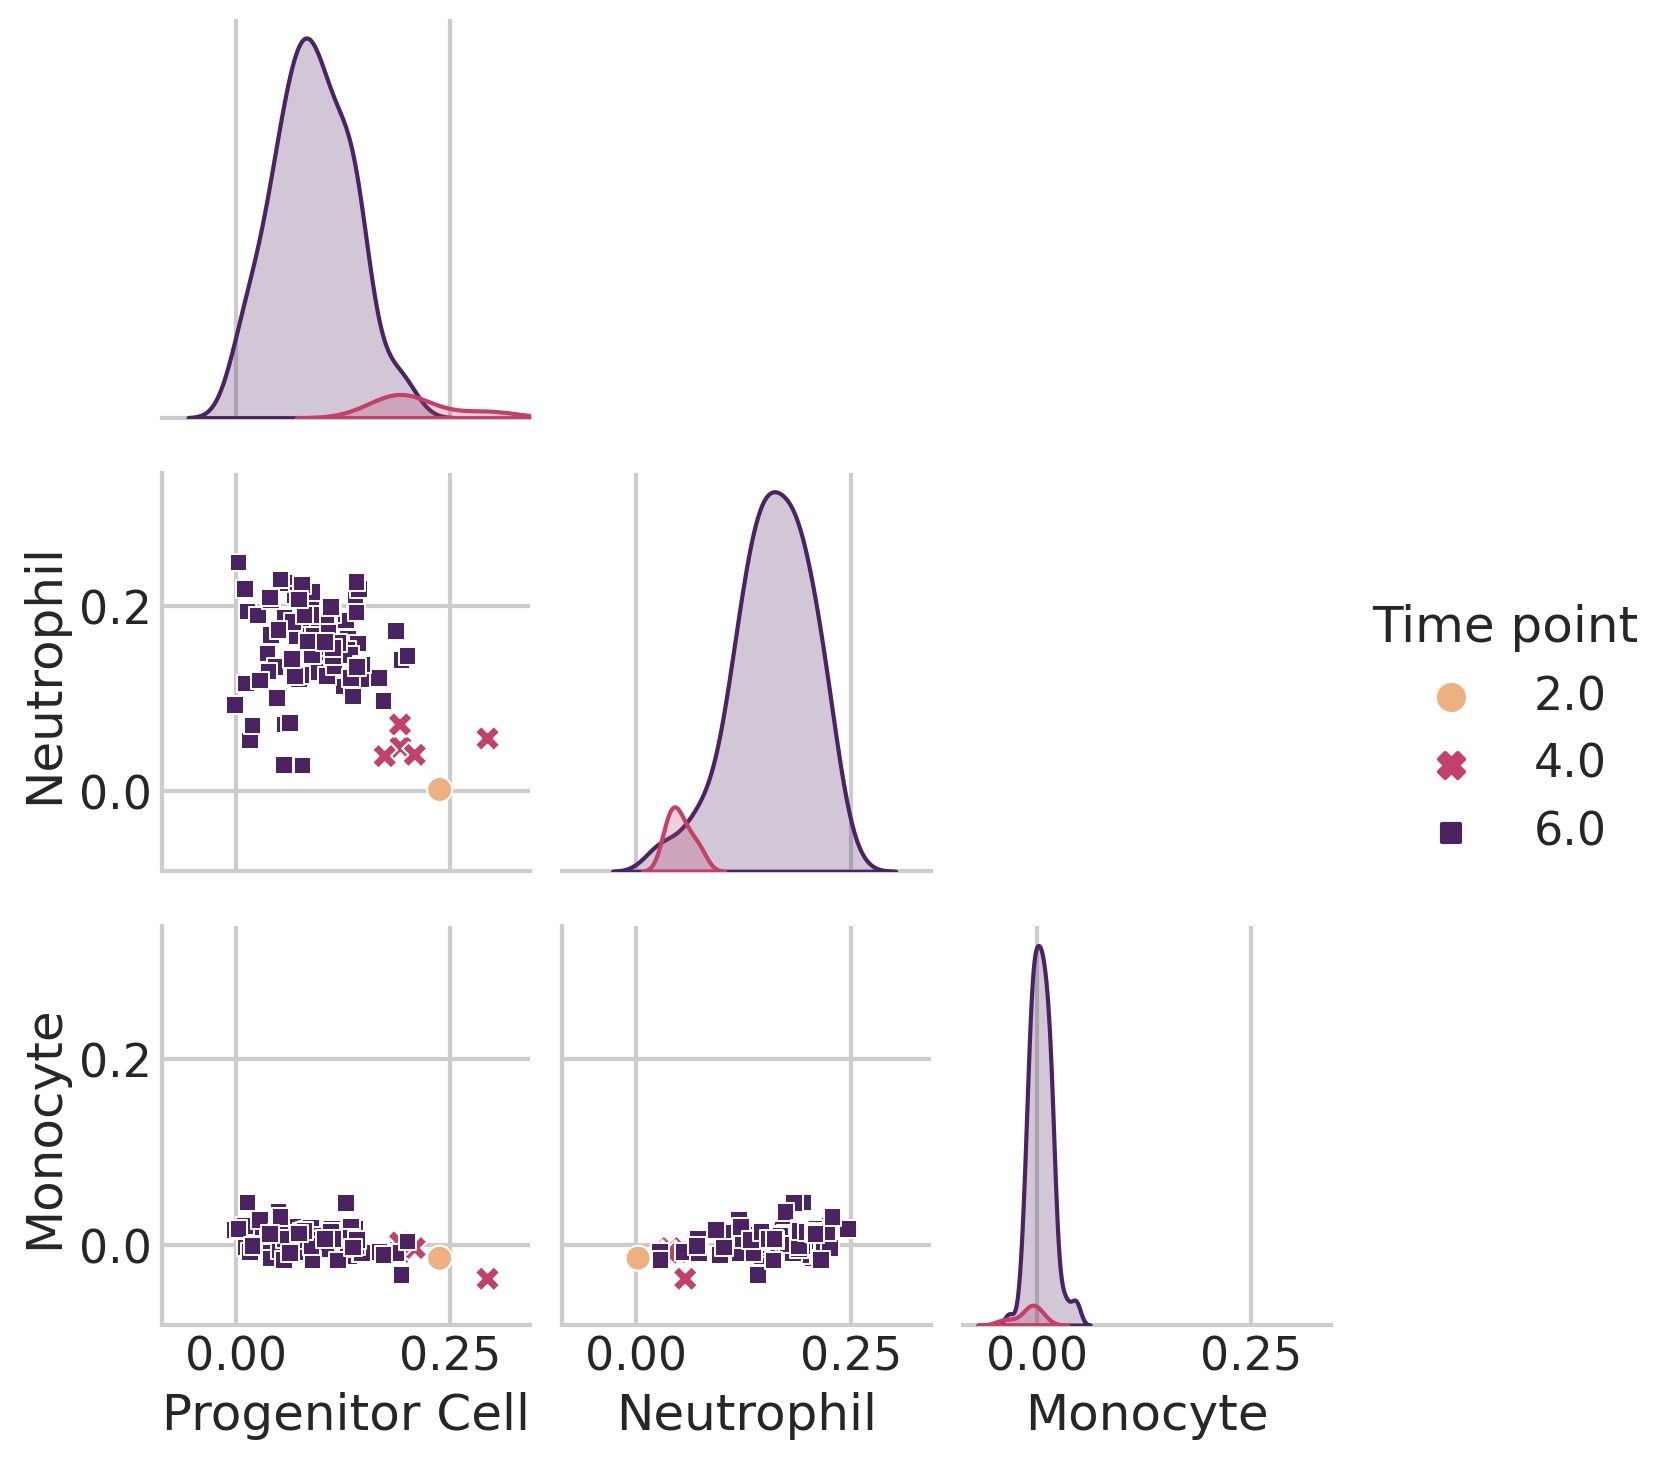

In [43]:
# g = pairplot = sns.pairplot(clones_data, hue='Clone', palette='tab10',
#                             vars=['6.0 Neutrophil',
#                                   '6.0 Monocyte',
#                                   '6.0 Meg',
#                                   '6.0 Mast',
#                                   '6.0 Eos',
#                                   '6.0 Baso',
#                                   '2.0 Undifferentiated'
#                                  ], 
#                             plot_kws=dict(style=clones_data.loc[:,'Time point'], s=60),
#                            )

g = pairplot = sns.pairplot(clones_data, hue='Time point', palette='flare',
                            vars=[
                                   'Progenitor Cell',
                                  'Neutrophil',
                                  'Monocyte',
#                                   'Megakaryocyte',
#                                   'Mast Cell',
#                                   'Eosiniphil',
#                                   'Basophil',
                                 ], 
                            plot_kws=dict(style=clones_data.loc[:,'Time point']),
                            corner=True
                           )


# limits = [-0.15, 0.35]
limits = [min(clones_data.min()) - 0.05, max(clones_data.drop(columns='Time point').max()) + 0.05]
for ax in g.axes.flat:
    if ax == None:
        continue
    ax.set(xlim=limits, ylim=limits)
plt.savefig('./manuscript figures/hem neutro pairplot.png')
plt.show()

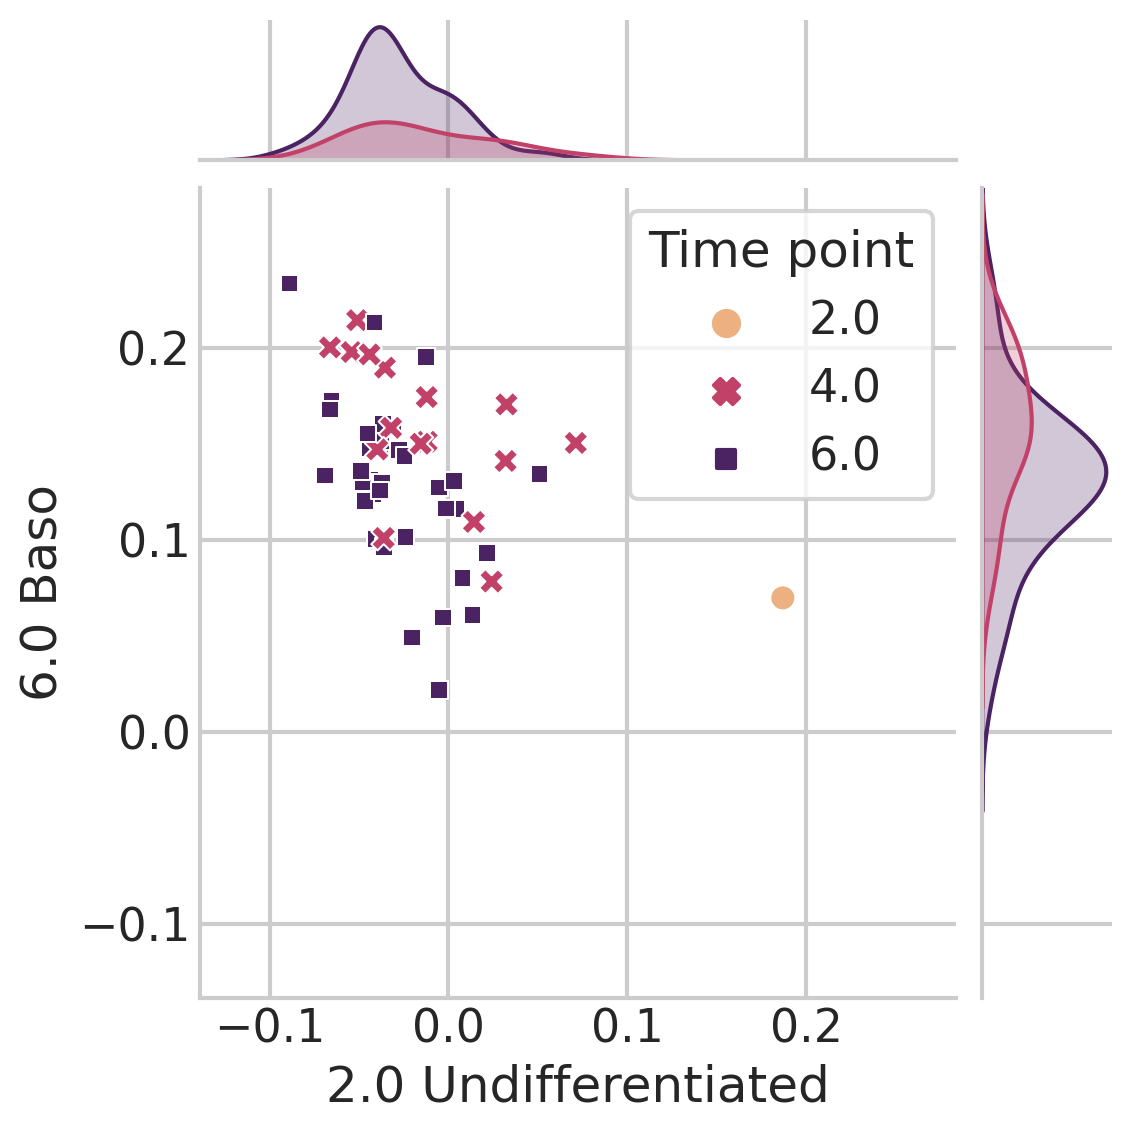

In [82]:
sns.jointplot(data=clones_data, y="6.0 Baso", x="2.0 Undifferentiated", hue="Time point", palette='flare',
             joint_kws=dict(style=clones_data.loc[:,'Time point']),
              xlim = limits, ylim=limits
             )

In [8]:
current_indices = clones_indices

clones_counts = counts_vitro.loc[:,current_indices]
clones_processed = top.process(clones_counts)
clones_scores = top.score(day6_basis, clones_processed)

metadata_clones = metadata_vitro.iloc[current_indices]
clones_days = metadata_clones.loc[:,'Time point']
clones_data = pd.concat([clones_scores.T, clones_days], axis=1)

In [ ]:
# Neutrophil genes from Weinreb et al.: S100a8, Elane
# Monocyte genes: Csf1r, Klf4
# DC genes: Cd74, H2-Aa

genes = ['S100a8', 'Elane', 'Csf1r', 'Klf4', 'Cd74', 'H2-Aa']

for gene in genes:
    # gene = 'Csf1r'
    gene_index = np.where(clones_counts.index == gene)[0]
    gene_array = clones_counts.iloc[gene_index].values[0]

    size_scale = 4
    fig, axes = plt.subplots(1, 4, figsize=(4*size_scale,1*size_scale))
    axes_list = axes.flatten()

    type1 = '2.0 Undifferentiated'
    type2 = '6.0 Neutrophil'
    type3 = '6.0 Monocyte'

    markersize = plt.rcParams['lines.markersize'] **0.9
    bounds = [-0.2, 0.55]

    type_pairs = [[type1, type2], [type2, type3], [type1, type3]]
    axis_index = 0

#     hue_norm = (min(gene_array), max(gene_array))
    hue_norm = (0, 40)
    palette = 'Spectral'

    for typeX, typeY in type_pairs:
        ax = axes_list[axis_index]

        scatter = sns.scatterplot(x=clones_data.loc[:, typeX],
                        y=clones_data.loc[:, typeY],
                        hue=gene_array,
                        hue_norm = hue_norm,
                        legend=False,
                        palette=palette,
                        linewidth=0.15,
                        s = markersize,
                        ax=ax,
                       )

        ax.set(xlabel = label_dict[typeX],
               ylabel = label_dict[typeY],
               xlim = bounds,
               ylim = bounds,
    #            aspect = 'equal',
    #            xticks = np.arange(5)/10.,
    #            yticks = np.arange(5)/10.,
              )
    #         ax.grid()
    #     plt.colorbar(gene_array, ax=ax)
        axis_index += 1

    plt.tight_layout()

    ax = axes_list[axis_index]
    cb_ax = create_colorbar(hue_norm, gene, colormap=palette, cax = ax)

    bbox=ax.get_position()
    ax.set_position([bbox.x0-0.06, bbox.y0+0.03, (bbox.x1 - bbox.x0)*0.1, (bbox.y1 - bbox.y0)*0.9], which='both')
    # ax.set_aspect(4)

#     plt.savefig("./manuscript figures/hem mono-neutrophil gene {}.png".format(gene), transparent=True)
    plt.show()

In [55]:
limits = [-0.2, 0.55]
bins = np.linspace(*limits, 100)
grid = np.meshgrid(bins, bins)

day2_dataframe = clones_data[clones_data.loc[:,'Time point'] == 2.0].drop(columns='Time point')
day4_dataframe = clones_data[clones_data.loc[:,'Time point'] == 4.0].drop(columns='Time point')
day6_dataframe = clones_data[clones_data.loc[:,'Time point'] == 6.0].drop(columns='Time point')

dataframes = [day2_dataframe, day4_dataframe, day6_dataframe]
days = [2, 4, 6]

def create_histogram(dataframe, type1, type2, bins):
    histogram = np.histogram2d(x = dataframe.loc[:, type1],
                               y = dataframe.loc[:, type2],
                               bins = bins
                              )
    histogram = pd.DataFrame(histogram[0].T) # take the transpose because np.histogram2d doesn't follow usual x/y conventions
    histogram = histogram/histogram.sum().sum()
    return histogram

def time_distribution(type1, type2, bins):
    weighted_sum = 0
    hist_sum = 0
    for day, dataframe in zip(days, dataframes):
        histogram = create_histogram(dataframe, type1, type2, bins)
        weighted_sum += day*histogram
        hist_sum += histogram

    return weighted_sum/hist_sum

/scratch/146686.1.ood/ipykernel_17544/2096346283.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colormesh = ax.pcolormesh(grid[0], grid[1],
/scratch/146686.1.ood/ipykernel_17544/2096346283.py:29: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(colormesh, label='Days in culture', location='bottom')
/scratch/146686.1.ood/ipykernel_17544/2096346283.py:29: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(colormesh, label='Days in culture', location='bottom')


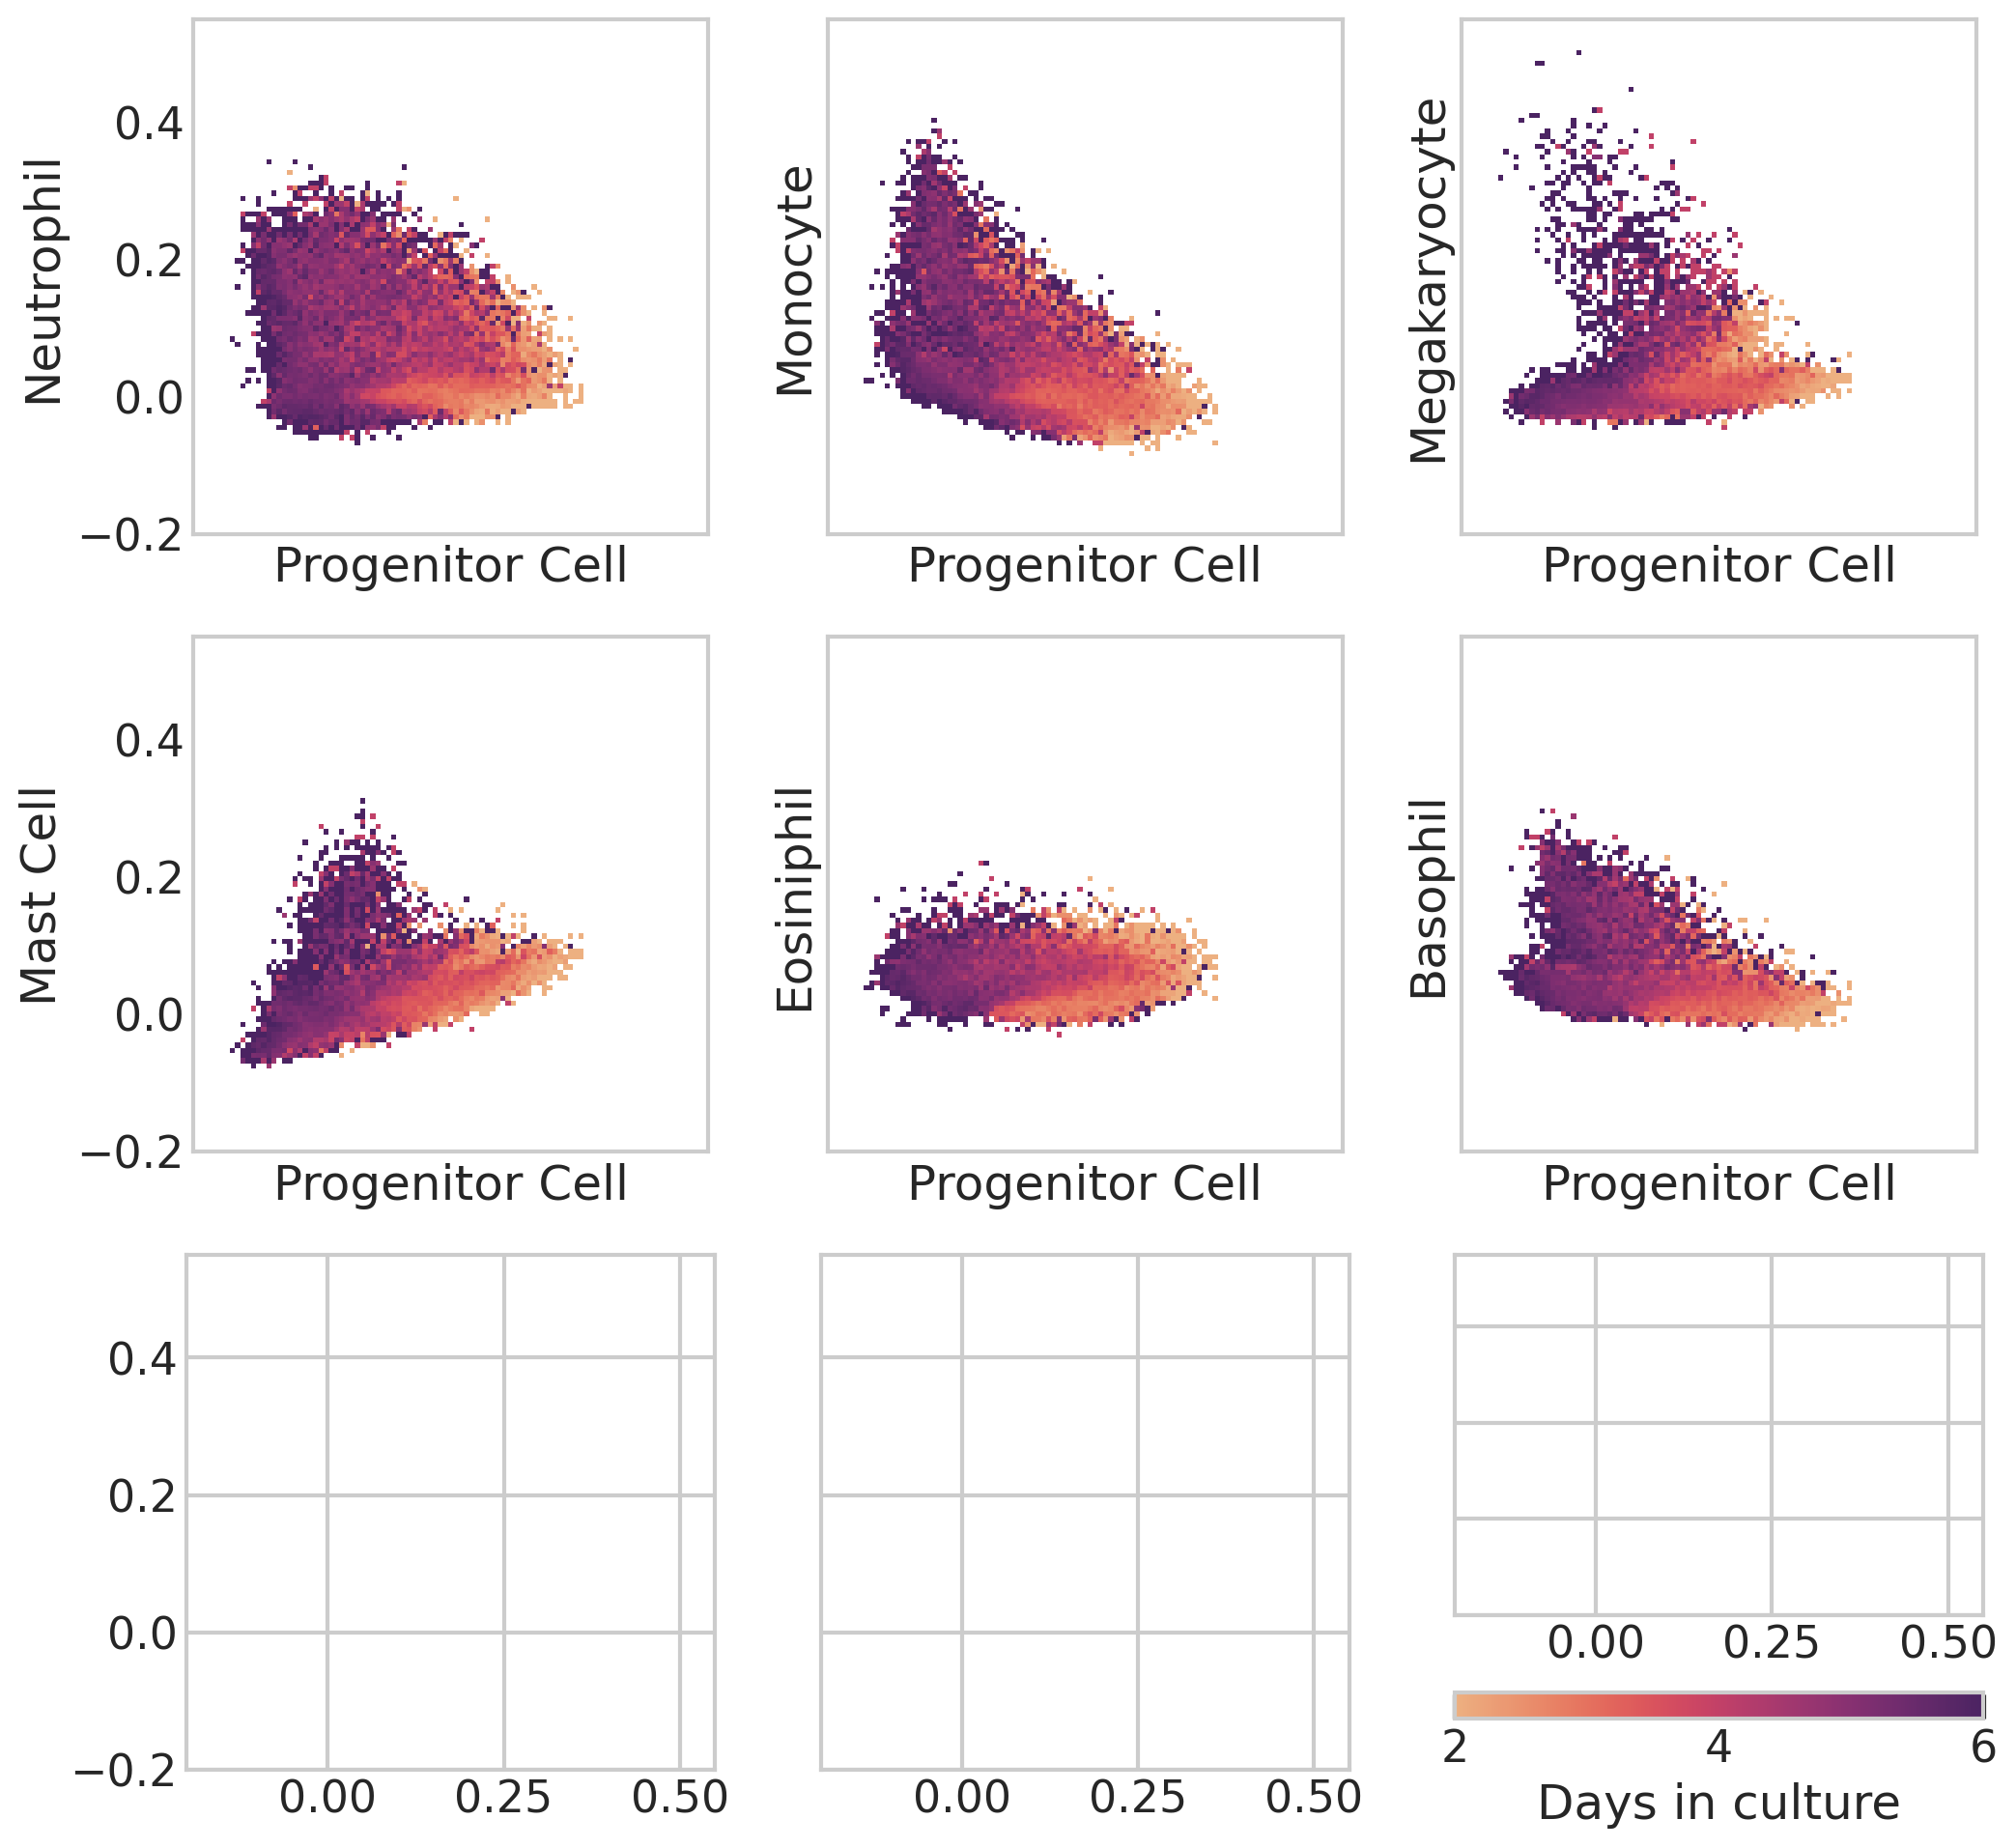

In [59]:
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12,12))
axes_list = axes.flatten()

axis_index = 0
for type1 in day6_types:
    if type1 != day6_types[-1]:
        continue
        
    for type2 in day6_types:
        if type2 == type1:
            break
            
        ax = axes_list[axis_index]
        ax.set_box_aspect(1)
        colormesh = ax.pcolormesh(grid[0], grid[1],
                                  time_distribution(type1, type2, bins),
                                  vmin=2, vmax=6,
                                  cmap='flare'
                                 )
        
        ax.set(xlim=limits, 
               ylim=limits,
               xlabel=label_dict[type1], 
               ylabel=label_dict[type2]
              )
        
        axis_index+=1 
        
plt.colorbar(colormesh, label='Days in culture', location='bottom')
plt.tight_layout
        
fig.savefig('./manuscript figures/fig4 2d histograms - progenitor (flare).png', bbox_inches = "tight")
fig.show()

/scratch/146686.1.ood/ipykernel_17544/3666820796.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  colormesh = ax.pcolormesh(grid[0], grid[1],
/scratch/146686.1.ood/ipykernel_17544/3666820796.py:32: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(colormesh, label='Days in culture', location='bottom')
/scratch/146686.1.ood/ipykernel_17544/3666820796.py:32: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(colormesh, label='Days in culture', location='bottom')


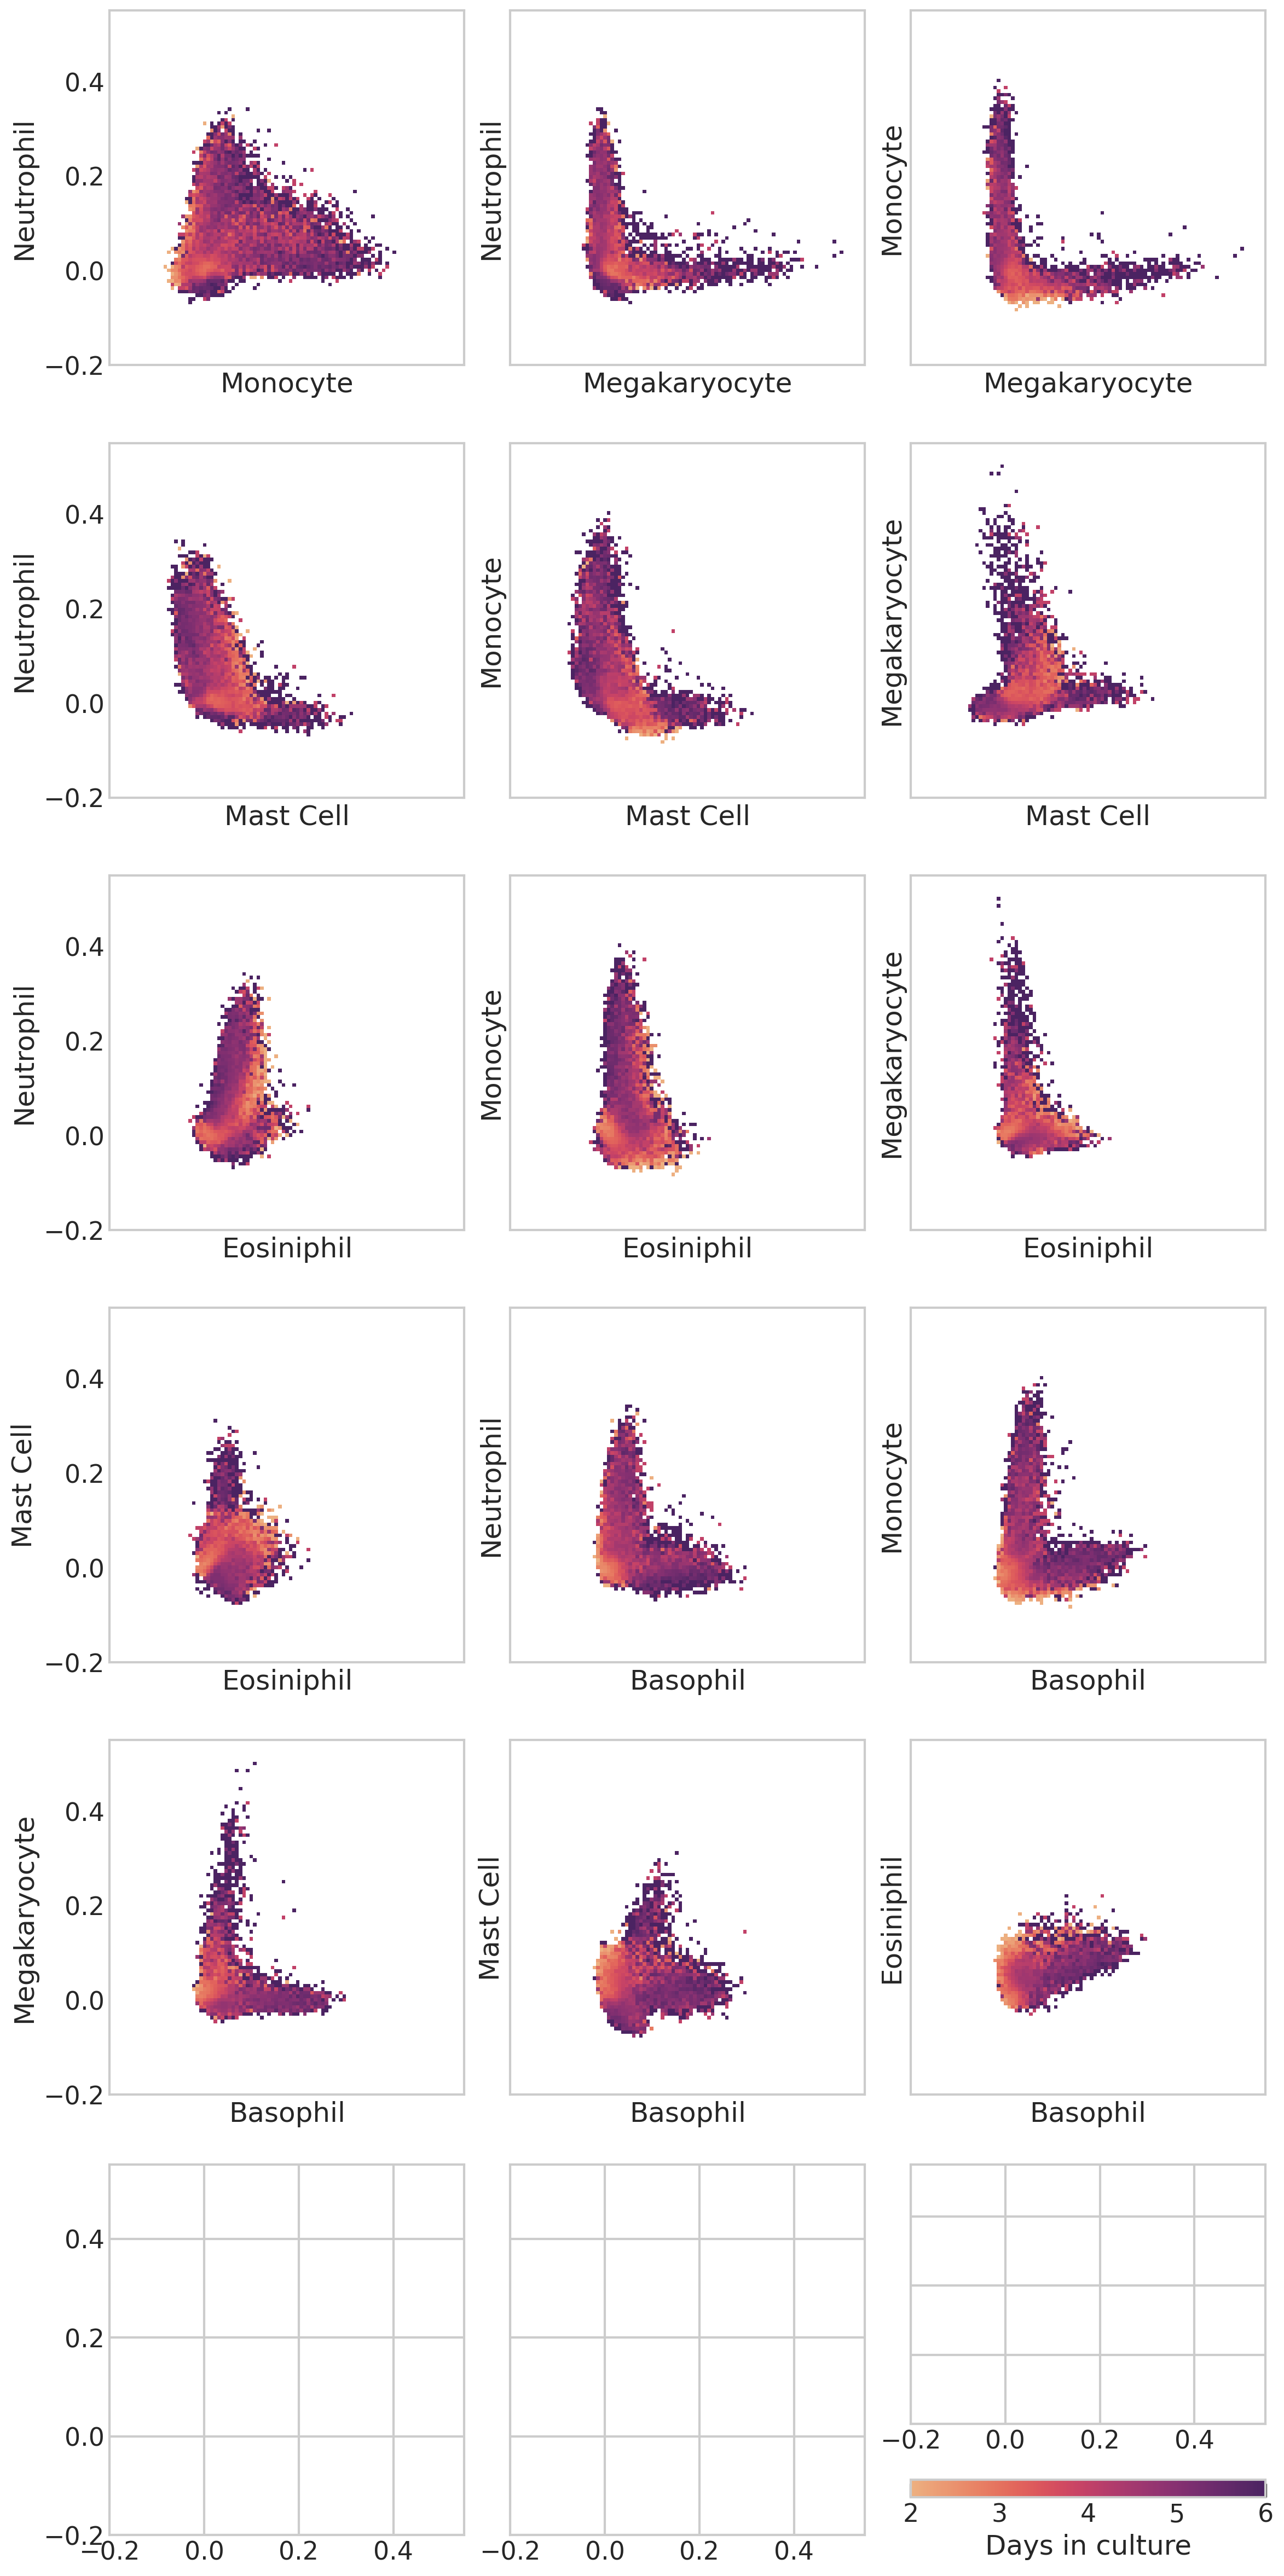

In [63]:
fig, axes = plt.subplots(6, 3, sharex=True, sharey=True, figsize=(12,24))
axes_list = axes.flatten()

axis_index = 0
for type1 in day6_types:
    if type1 == day6_types[-1]:
        continue
    
    for type2 in day6_types:
        if type2 == type1:
            break
            
        ax = axes_list[axis_index]
        ax.set_box_aspect(1)
        colormesh = ax.pcolormesh(grid[0], grid[1],
                                  time_distribution(type1, type2, bins),
                                  vmin=2, vmax=6,
                                  cmap='flare'
                                 )
        
        ax.set(xlim=limits, 
               ylim=limits,
               xlabel=label_dict[type1], 
               ylabel=label_dict[type2]
              )
        
#         plt.colorbar(colormesh, ax=ax, label='Days in culture')
        
        axis_index+=1 
        
        
plt.colorbar(colormesh, label='Days in culture', location='bottom')
plt.tight_layout()
fig.savefig('./manuscript figures/fig4 2d histograms - mature types (flare).png')
fig.show()

/scratch/127734.1.ood/ipykernel_626/4137777658.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(pcm)


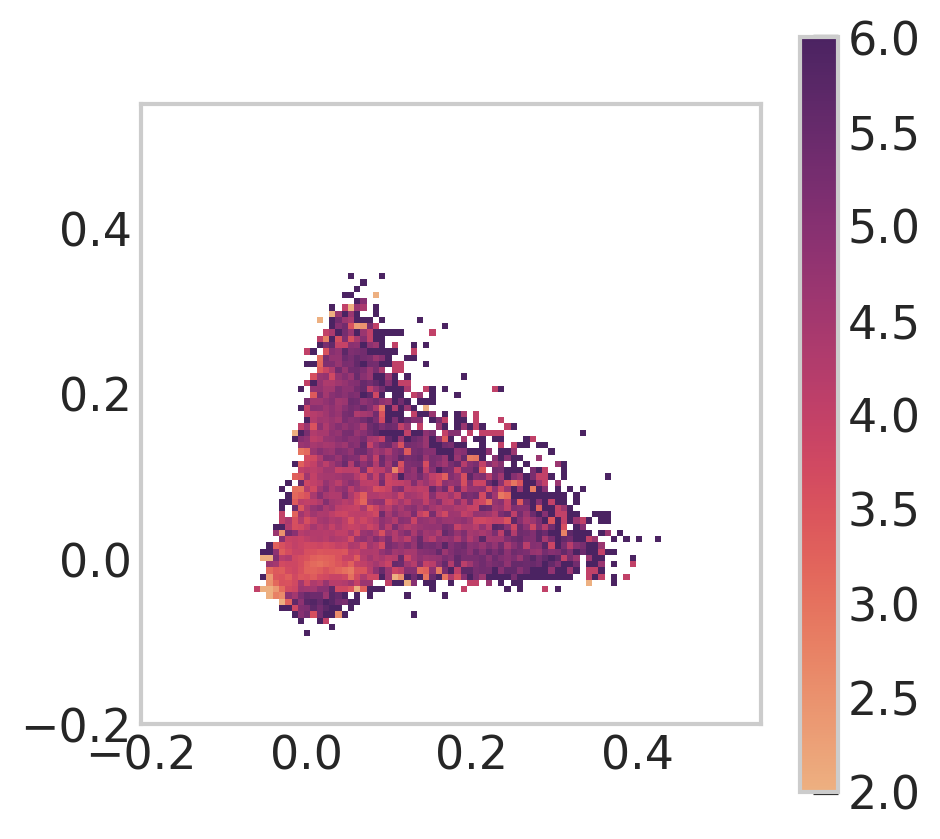

In [29]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, aspect='equal')
ax.grid(False)
pcm = ax.pcolormesh(grid[0], grid[1], total, vmin=2, vmax=6, cmap='flare')
plt.colorbar(pcm)
fig.show()

From [github](https://github.com/AllonKleinLab/paper-data/tree/master/Lineage_tracing_on_transcriptional_landscapes_links_state_to_fate_during_differentiation):

## Experiment 2: In vivo differentiation time course
"In this experiment, we isolated hematopoietic progenitor cells from mouse bone marrow, tagged them using the LARRY lentiviral barcode library, and then transplanted them into sublethally irradiated host mice. Cells were profiled on day 2 (just before transplantation) and days 9 and 16 (one and two weeks post-transplantation). See above for a detailed description of each file."

In [4]:
source_vivo = '/projectnb/biophys/mariay/mouse/samples/GSE140802 (bone marrow)/GSM4185643_'

metadata_vivo = pd.read_csv(source_vivo + 'stateFate_inVivo_metadata.txt', sep='\t')
counts_vivo = mmread(source_vivo + 'stateFate_inVivo_normed_counts.mtx')
clones_vivo = mmread(source_vivo + 'stateFate_inVivo_clone_matrix.mtx').tocsr().T
genes_vivo = pd.read_csv(source_vivo + 'stateFate_inVivo_gene_names.txt', sep='\t', header=None)

counts_vivo = pd.DataFrame.sparse.from_spmatrix(counts_vivo).T
counts_vivo.index = genes_vivo.T.values[0]

# Indices of cells that have clones
clones_indices = clones_vivo.nonzero()[0]

enumerated_clones, clone_counts = np.unique(clones_vivo.nonzero()[1], return_counts=True)

time_points_types, type_counts = np.unique(metadata_vivo.loc[:, 'Time point'].astype('string') + ' ' 
                                           + metadata_vivo.loc[:, 'Cell type annotation'], return_counts=True)

In [123]:
clones_indices = clones_vivo.nonzero()[0]

enumerated_clones, clone_counts = np.unique(clones_vivo.nonzero()[1], return_counts=True)

time_points_types, type_counts = np.unique(metadata_vivo.loc[:, 'Time point'].astype('string') + ' ' 
                                           + metadata_vivo.loc[:, 'Cell type annotation'], return_counts=True)

<BarContainer object of 21 artists>

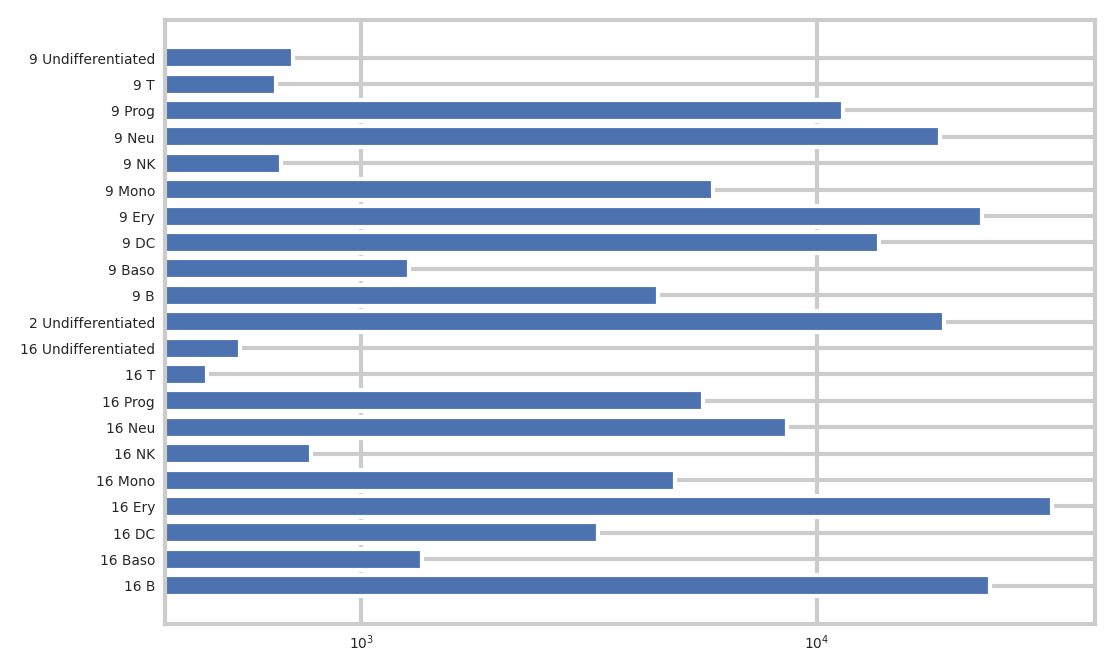

In [134]:
plt.barh(time_points_types, type_counts,log=True)

In [17]:
clone_time_points = pd.DataFrame(index=enumerated_clones,
                                 columns=['Day 2', 'Day 9', 'Day 16'])

days = [2., 9., 16.]

# For each clone column, find which clones have multi-day sisters
for current_clone in enumerated_clones:
    current_sisters = clones_vivo[:,current_clone].nonzero()[0]
    current_timepoints = metadata_vivo.iloc[current_sisters].loc[:, 'Time point']
    for day in days:
        clone_time_points.loc[
            current_clone, "Day {}".format(int(day))] = (len(
            np.where(current_timepoints == day)[0]))

In [43]:
clone_time_points.sort_values(by='Day 2', ascending=False)

,Day 2,Day 9,Day 16
6439,13,235,0
8656,10,0,0
5587,9,198,0
9858,8,152,0
6699,8,127,0
...,...,...,...
10983,0,9,0
10985,0,1,0
10989,0,0,1
10990,0,2,0


In [51]:
# Make the basis from in vivo day 16 samples

type_by_cell = (metadata_vivo.loc[:, 'Time point'].astype('string') + ' ' 
                                           + metadata_vivo.loc[:, 'Cell type annotation'])

day16_types = time_points_types[:9]
day16_counts = type_counts[:9]

day16_types = day16_types[day16_counts>200]
day16_counts = day16_counts[day16_counts>200]

type_expressions_list = []
training_indices = []
types_kept = []

for current_type in tqdm(day16_types):
    current_type_indices = np.where(type_by_cell==current_type)[0]

    # Drop cloned types
    current_type_indices = np.setdiff1d(current_type_indices, clones_indices)

    # Choose n_training cells to use for the basis
    n_training = 150
    
    if len(current_type_indices) < n_training:
        continue
    
    types_kept += [current_type]
    random_indices = np.random.choice(current_type_indices, n_training, replace=False)
    training_indices += [random_indices]
    
    current_raw = counts_vivo.iloc[:, random_indices]
    current_processed = top.process(current_raw, average=True)
    type_expressions_list.append(current_processed)


training_indices = np.concatenate(training_indices)
day16_basis = pd.concat(type_expressions_list, axis=1)
day16_basis.columns = types_kept

100%|██████████| 9/9 [00:01<00:00,  7.35it/s]


In [ ]:
current_indices = clones_indices
# clone_family = 6439
# current_indices = clones_vivo[:,clone_family].nonzero()[0]

# current_indices = metadata_vivo[metadata_vivo.loc[:, 'Time point'] == 2].index

clones_counts = counts_vivo.loc[:,current_indices]
clones_processed = top.process(clones_counts)
clones_scores = top.score(day16_basis, clones_processed)

metadata_clones = metadata_vivo.iloc[current_indices]
hue_variable = 'Time point'
clones_days = metadata_clones.loc[:,hue_variable]
clones_data = pd.concat([clones_scores.T, clones_days], axis=1)

In [ ]:
g = pairplot = sns.pairplot(clones_data, hue=hue_variable, palette='crest',
#                             plot_kws=dict(style=clones_data.loc[:,'Time point']),
                           )

limits = [-0.15, 0.5]
for ax in g.axes.flat:
    if ax == None:
        continue
    ax.set(xlim=limits, ylim=limits)
    
plt.show()
# g.fig.savefig("./vivo clone {}.png".format(clone_family), bbox_inches = "tight")

In [ ]:
g.fig.savefig("./vivo all clones.png", bbox_inches = "tight")

In [66]:
multiday_clones = [] # indices of clone families with at least 1 day 2 clone
                     # and at least 1 day 9 or day 16 clone

for clone, row in clone_time_points.iterrows():
    has_day2 = row['Day 2'] > 0
    has_day9 = row['Day 9'] > 0
    has_day16 = row['Day 16'] > 0
    
    if has_day2 and (has_day9 or has_day16):
        multiday_clones += [clone]

In [90]:
current_indices = clones_vivo[:, 6439].nonzero()[0]
current_metadata = metadata_vivo.loc[current_indices]
current_outputs = current_metadata.loc[current_metadata.loc[:,'Time point'] > 2].loc[:, 'Cell type annotation']
np.unique(current_outputs, return_counts=True)

(array(['B', 'Baso', 'DC', 'Ery', 'Mono', 'Neu', 'Prog',
        'Undifferentiated'], dtype=object),
 array([ 1,  1, 41, 95, 15, 40, 39,  3]))

In [ ]:
# Look at day 2 data, plot neutrophil, erythroid, and monocyte
# Color according to most-common lineage among differentiated sister
# Size according to proportion of most-common lineage

current_indices = clones_vivo[:, multiday_clones].nonzero()[0]

clones_counts = counts_vivo.loc[:,current_indices]
clones_processed = top.process(clones_counts)
clones_scores = top.score(day16_basis, clones_processed)

metadata_clones = metadata_vivo.loc[current_indices]
clones_days = metadata_clones.loc[:,'Time point']
clones_data = pd.concat([clones_scores.T, clones_days], axis=1)

In [ ]:
g = pairplot = sns.pairplot(clones_data, hue='Time point', palette='flare'
                           )

limits = [-0.15, 0.5]
for ax in g.axes.flat:
    if ax == None:
        continue
    ax.set(xlim=limits, ylim=limits)
    
plt.show()

/scratch/154430.1.ood/ipykernel_6741/2871077949.py:1: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.hist2d(clones_data.iloc[:, 0], clones_data.iloc[:, 1], bins=(50, 50), cmap='mako_r')
/scratch/154430.1.ood/ipykernel_6741/2871077949.py:2: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


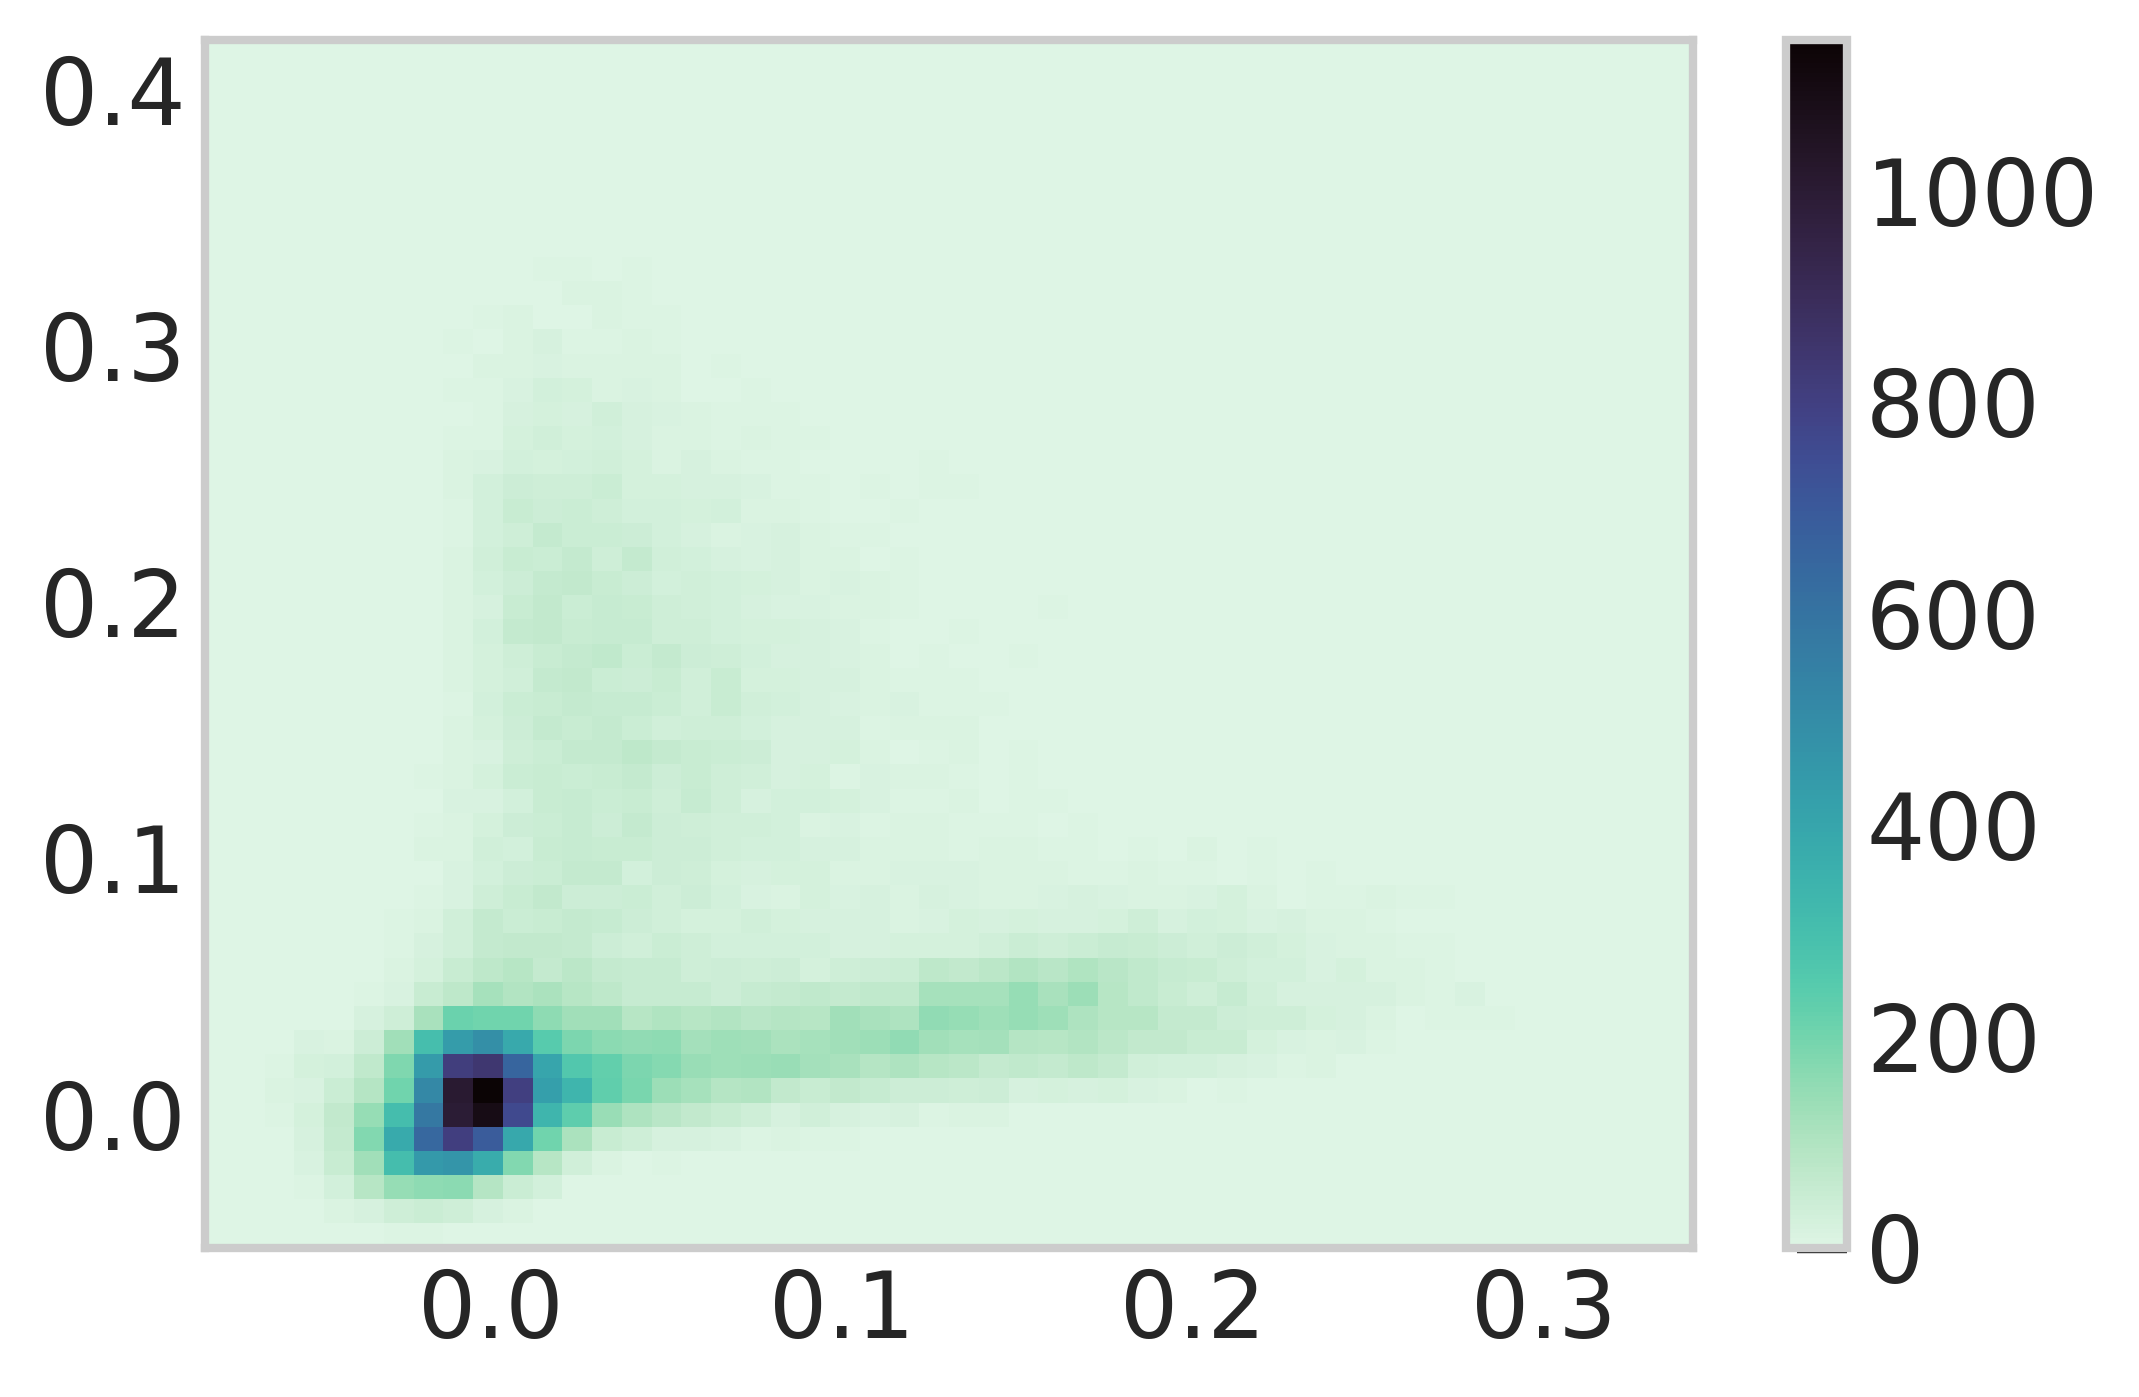

In [31]:
plt.hist2d(clones_data.iloc[:, 0], clones_data.iloc[:, 1], bins=(50, 50), cmap='mako_r')
plt.colorbar()
plt.show()